# Isolation Forest for anomaly detection (With Labels)

### Import Library

In [59]:
import os
import sys
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

# Go to root dir
# sys.path.append(os.path.abspath(".."))

from src.load_data import load_sheet, clean_sheet_with_label
from src.isolation_forest import create_pipeline, score_and_map_anomalies, tuning_contamination_rate, plot_anomaly_detection

%load_ext autoreload
%matplotlib
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using matplotlib backend: module://matplotlib_inline.backend_inline


In [60]:
internal_df, sheet1 = load_sheet("Electroplate Experiments Data JUN_JUL", "vary_internal_table")
internal_df = clean_sheet_with_label(internal_df)
# two_side_plate, sheet2 = load_sheet("Electroplate Experiments Data JUN_JUL", "2 side Experimental Result")
# two_side_plate = clean_sheet_with_label(two_side_plate)
august_df, sheet3 = load_sheet("Electroplating Experiments Data August", "Sheet1")
august_df = clean_sheet_with_label(august_df)
september_df, sheet4 = load_sheet("Electroplating Experiments Data September", "Sheet1")
september_df = clean_sheet_with_label(september_df)

In [61]:
df = pd.concat([internal_df, august_df, september_df]).reset_index(drop=True)
df['index'] = df.groupby('run_id').cumcount() + 1
time_index_series = df.pop('index')
df.insert(0, 'index', time_index_series)

In [62]:
df

,index,run_id,timestamp,time,time_total,area,cathode,anode,mass_SLS,mass_NISO4,...,pH,Anomaly P,temperature,Anomaly T,voltage,Anomaly V,current,amp_hour,deposition_rate,bath_id
0,1,JUL_3_1,2025-07-03 11:21:05,1,1,67,Brass,Nickel,0.80,270.0,...,4.02,,50.36,,3.649,,2.342,0.001000,0.6289,Fresh
1,2,JUL_3_1,2025-07-03 11:21:06,1,2,67,Brass,Nickel,0.80,270.0,...,4.02,,50.35,,3.568,,2.342,0.001000,0.6289,Fresh
2,3,JUL_3_1,2025-07-03 11:21:07,1,3,67,Brass,Nickel,0.80,270.0,...,4.02,,50.35,,3.509,,2.342,0.002000,0.6289,Fresh
3,4,JUL_3_1,2025-07-03 11:21:08,1,4,67,Brass,Nickel,0.80,270.0,...,4.02,,50.35,,3.509,,2.342,0.003000,0.6289,Fresh
4,5,JUL_3_1,2025-07-03 11:21:09,1,5,67,Brass,Nickel,0.80,270.0,...,4.02,,50.35,,3.475,,2.342,0.003000,0.6289,Fresh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70544,594,OCT_17_99,2025-07-22 15:11:21,2,11954,67,Brass,Nickel,0.35,270.0,...,4.10,None,49.74,None,3.334,None,2.343,7.780593,0.6310,Bath_9
70545,595,OCT_17_99,2025-07-22 15:11:23,2,11956,67,Brass,Nickel,0.35,270.0,...,4.10,None,49.74,None,3.339,None,2.343,7.781895,0.6310,Bath_9
70546,596,OCT_17_99,2025-07-22 15:11:25,2,11958,67,Brass,Nickel,0.35,270.0,...,4.10,None,49.76,None,3.334,None,2.343,7.783196,0.6310,Bath_9
70547,597,OCT_17_99,2025-07-22 15:11:28,2,11960,67,Brass,Nickel,0.35,270.0,...,4.10,None,49.75,None,3.340,None,2.343,7.784498,0.6310,Bath_9


In [63]:
SENSOR_FEATURES = ["conductivity", "temperature", "pH",	"voltage"]
TRAIN_RUNS = ['JUL_22_1','JUL_22_2', 'JUL_22_3', 'JUL_22_4', 'JUL_22_5', 'JUL_22_6','JUL_22_7', 'JUL_22_8', 'JUL_22_9', 
			  'JUL_23_1', 'JUL_23_2', 'JUL_23_3', 'JUL_23_4', 'JUL_23_5']
TEST_RUNS = ['JUL_24_1', 'JUL_24_2',
       'JUL_24_3', 'JUL_24_4', 'JUL_24_5', 'JUL_24_6', 'JUL_24_7',
       'JUL_24_8', 'JUL_24_9', 'JUL_24_10']

NORMAL_RUNS = ['JUL_22_4', 'JUL_22_5', 'JUL_22_7']
NORMAL_CONDUCTIVITY_RUNS = ['JUL_22_1','JUL_22_2', 'JUL_22_4', 'JUL_22_5', 'JUL_22_7']

In [64]:
df_train = df[df['run_id'].isin(TRAIN_RUNS)].reset_index(drop=True)
df_train.index = df_train['run_id'].index + 1
df_train

,index,run_id,timestamp,time,time_total,area,cathode,anode,mass_SLS,mass_NISO4,...,pH,Anomaly P,temperature,Anomaly T,voltage,Anomaly V,current,amp_hour,deposition_rate,bath_id
1,1,JUL_22_1,2025-07-22 13:17:40,2,2,67,Brass,Nickel,0.35,270.0,...,4.02,N,49.70,N,3.639,N,2.342,0.002,0.6329,Bath_3
2,2,JUL_22_1,2025-07-22 13:17:42,2,4,67,Brass,Nickel,0.35,270.0,...,4.02,N,49.70,N,3.705,N,2.342,0.004,0.6329,Bath_3
3,3,JUL_22_1,2025-07-22 13:17:44,2,6,67,Brass,Nickel,0.35,270.0,...,4.02,N,49.71,N,3.702,N,2.342,0.006,0.6329,Bath_3
4,4,JUL_22_1,2025-07-22 13:17:46,2,8,67,Brass,Nickel,0.35,270.0,...,4.02,N,49.68,N,3.673,N,2.342,0.008,0.6329,Bath_3
5,5,JUL_22_1,2025-07-22 13:17:49,2,10,67,Brass,Nickel,0.35,270.0,...,4.02,N,49.69,N,3.668,N,2.342,0.010,0.6329,Bath_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8366,594,JUL_23_5,2025-07-23 14:18:59,2,16732,67,Brass,Nickel,0.35,270.0,...,4.21,N,49.77,N,3.437,V2,2.343,10.890,0.6301,Bath_3
8367,595,JUL_23_5,2025-07-23 14:19:01,2,16734,67,Brass,Nickel,0.35,270.0,...,4.21,N,49.75,N,3.493,V2,2.343,10.892,0.6301,Bath_3
8368,596,JUL_23_5,2025-07-23 14:19:03,2,16736,67,Brass,Nickel,0.35,270.0,...,4.21,N,49.75,N,3.508,V2,2.343,10.893,0.6301,Bath_3
8369,597,JUL_23_5,2025-07-23 14:19:05,2,16738,67,Brass,Nickel,0.35,270.0,...,4.21,N,49.73,N,3.564,V2,2.343,10.894,0.6301,Bath_3


In [65]:
df_test = df[df['run_id'].isin(TEST_RUNS)].reset_index(drop=True)
df_test

,index,run_id,timestamp,time,time_total,area,cathode,anode,mass_SLS,mass_NISO4,...,pH,Anomaly P,temperature,Anomaly T,voltage,Anomaly V,current,amp_hour,deposition_rate,bath_id
0,1,JUL_24_1,2025-07-24 09:26:30,2,16742,67,Brass,Nickel,0.35,270.0,...,4.23,,49.60,,3.988,,2.342,10.893,0.6326,Bath_3
1,2,JUL_24_1,2025-07-24 09:26:32,2,16744,67,Brass,Nickel,0.35,270.0,...,4.23,,49.61,,3.868,,2.342,10.895,0.6326,Bath_3
2,3,JUL_24_1,2025-07-24 09:26:34,2,16746,67,Brass,Nickel,0.35,270.0,...,4.22,,49.60,,3.893,,2.342,10.896,0.6326,Bath_3
3,4,JUL_24_1,2025-07-24 09:26:36,2,16748,67,Brass,Nickel,0.35,270.0,...,4.22,,49.61,,3.833,,2.342,10.897,0.6326,Bath_3
4,5,JUL_24_1,2025-07-24 09:26:38,2,16750,67,Brass,Nickel,0.35,270.0,...,4.22,,49.61,,3.824,,2.342,10.899,0.6326,Bath_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5965,594,JUL_24_10,2025-07-24 15:31:42,2,28672,67,Brass,Nickel,0.35,270.0,...,4.27,,49.98,,3.928,,2.678,21.325,0.7216,Bath_3
5966,595,JUL_24_10,2025-07-24 15:31:44,2,28674,67,Brass,Nickel,0.35,270.0,...,4.27,,49.98,,3.937,,2.678,21.326,0.7216,Bath_3
5967,596,JUL_24_10,2025-07-24 15:31:46,2,28676,67,Brass,Nickel,0.35,270.0,...,4.27,,49.97,,3.901,,2.678,21.334,0.7216,Bath_3
5968,597,JUL_24_10,2025-07-24 15:31:48,2,28678,67,Brass,Nickel,0.35,270.0,...,4.27,,49.98,,3.889,,2.678,21.329,0.7216,Bath_3


In [66]:
df_normal = df[df['run_id'].isin(NORMAL_RUNS)].reset_index(drop=True)
df_normal_conductivity = df[df['run_id'].isin(NORMAL_CONDUCTIVITY_RUNS)].reset_index(drop=True)

In [67]:
filtered_full_df = df[['run_id', 'conductivity', 'pH', 'temperature', 'voltage', 'index', 'timestamp']]
filtered_train_df = df_train[['run_id', 'conductivity', 'pH', 'temperature', 'voltage', 'index', 'timestamp']]
filtered_test_df = df_test[['run_id', 'conductivity', 'pH', 'temperature', 'voltage', 'index', 'timestamp']]
filtered_normal_df = df_test[['run_id', 'conductivity', 'pH', 'temperature', 'voltage', 'index', 'timestamp']]
filtered_normal_conductivity_df = df_test[['run_id', 'conductivity', 'pH', 'temperature', 'voltage', 'index', 'timestamp']]

# Trying full dataframe

In [68]:
isolation_forest_pipeline = create_pipeline()
X_train_scaled = isolation_forest_pipeline.fit(filtered_full_df)

# The pipeline's predict method automatically calls transform on the preceding steps.
predictions = isolation_forest_pipeline.predict(filtered_full_df)

# --- Score Alignment (Mapping results back to original data is now the manual step) ---
# FIX: Access the retained index directly from the fitted transformer instance attribute.
retained_index = isolation_forest_pipeline.named_steps['feature_generator'].retained_index_

# Create a full results series initialized to 'Normal' (1)
results = pd.Series(1, index=filtered_full_df.index)

# Map the predictions back to the correct rows
results.loc[retained_index] = predictions

X_score_full_df = score_and_map_anomalies(isolation_forest_pipeline, filtered_full_df)
X_score_full_df

,run_id,conductivity,pH,temperature,voltage,index,timestamp,anomaly_score,is_anomaly
0,JUL_3_1,55.37,4.02,50.36,3.649,1,2025-07-03 11:21:05,NaN,NaN
1,JUL_3_1,55.37,4.02,50.35,3.568,2,2025-07-03 11:21:06,NaN,NaN
2,JUL_3_1,55.37,4.02,50.35,3.509,3,2025-07-03 11:21:07,NaN,NaN
3,JUL_3_1,55.45,4.02,50.35,3.509,4,2025-07-03 11:21:08,NaN,NaN
4,JUL_3_1,55.45,4.02,50.35,3.475,5,2025-07-03 11:21:09,NaN,NaN
...,...,...,...,...,...,...,...,...,...
70544,OCT_17_99,55.75,4.10,49.74,3.334,594,2025-07-22 15:11:21,0.279623,1.0
70545,OCT_17_99,55.75,4.10,49.74,3.339,595,2025-07-22 15:11:23,0.279196,1.0
70546,OCT_17_99,55.75,4.10,49.76,3.334,596,2025-07-22 15:11:25,0.278595,1.0
70547,OCT_17_99,55.75,4.10,49.75,3.340,597,2025-07-22 15:11:28,0.278897,1.0


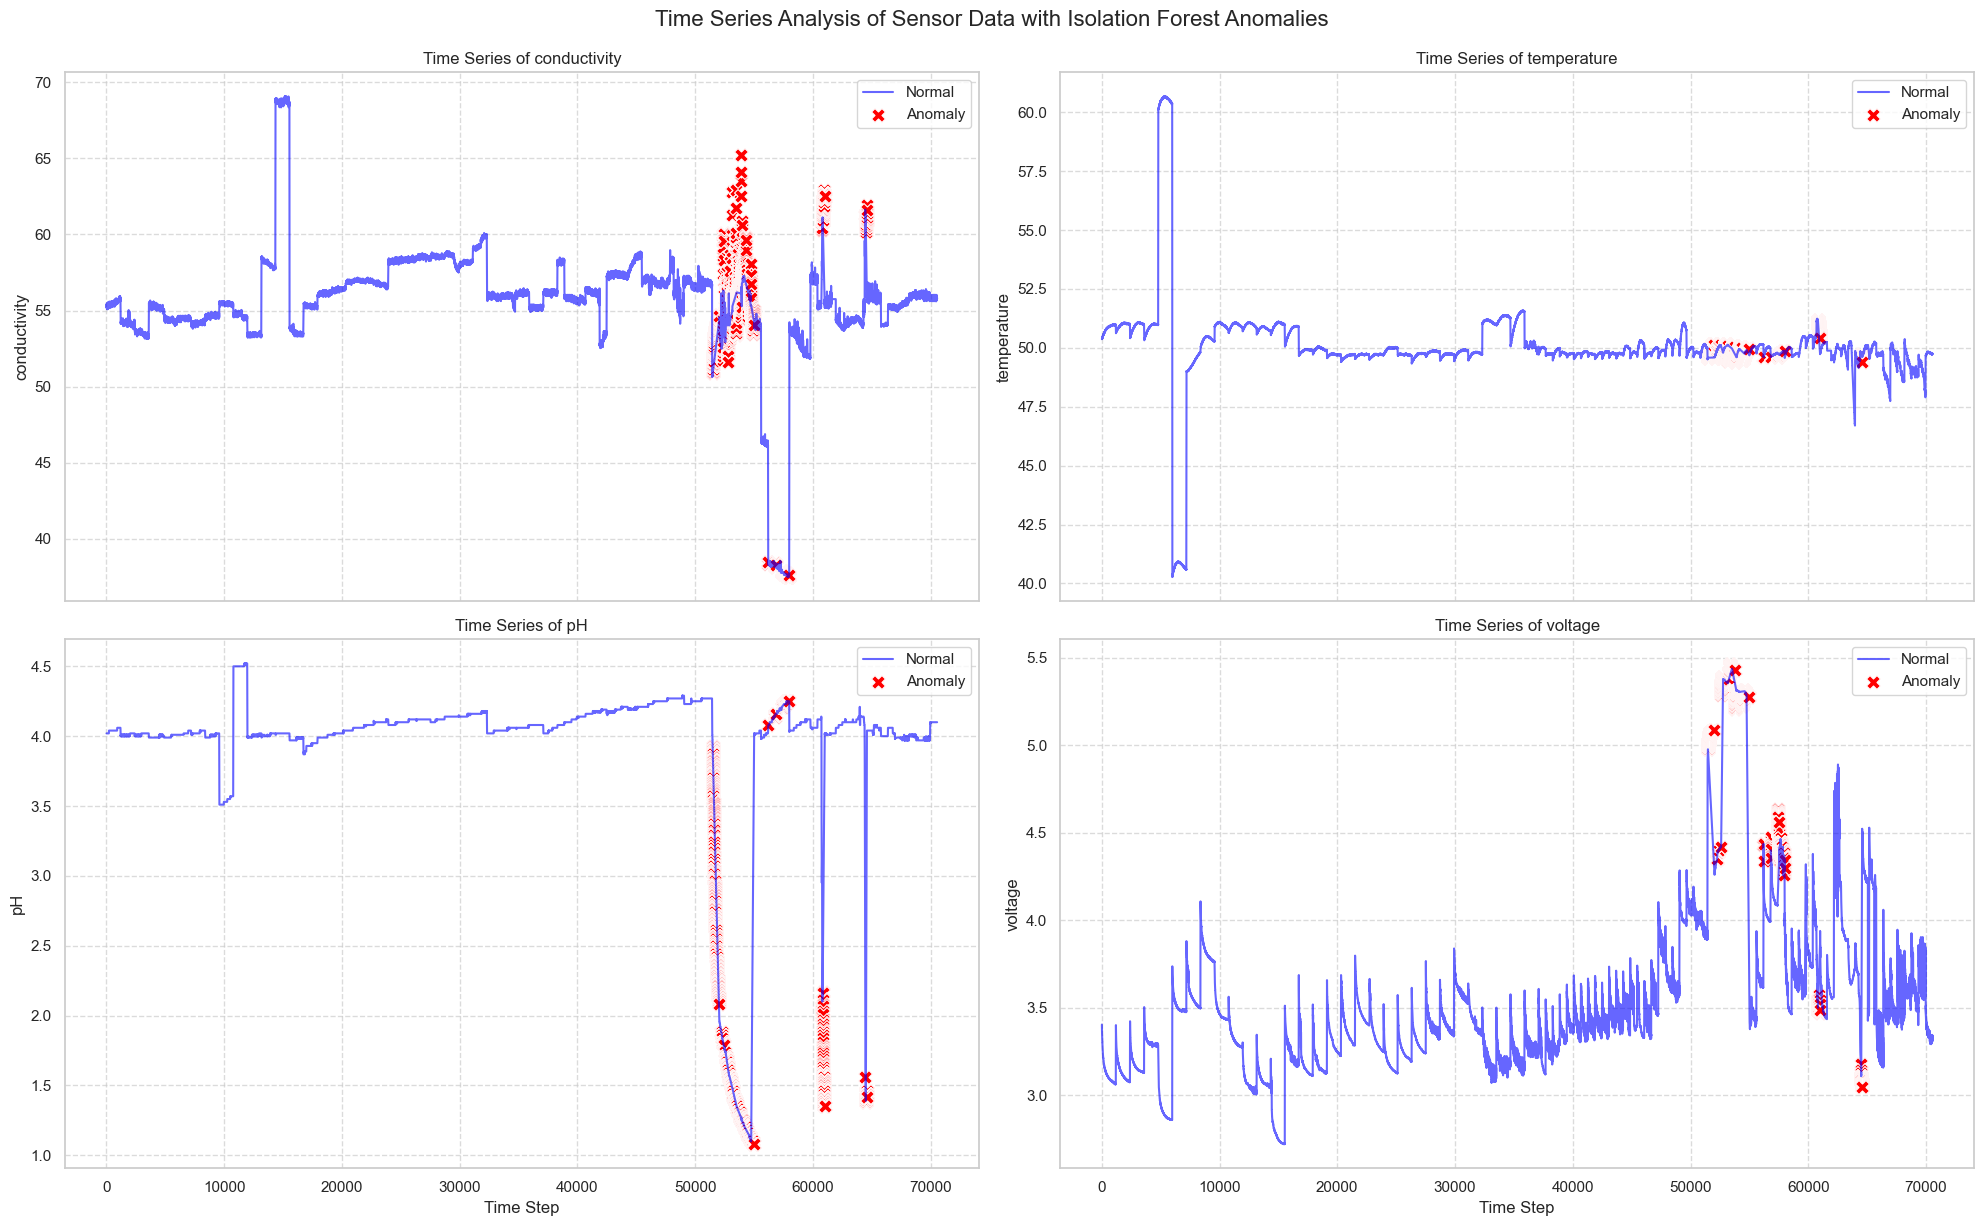

In [69]:
plot_anomaly_detection(X_score_full_df)

---

# Try training set

In [70]:
isolation_forest_pipeline = create_pipeline()
X_train_scaled = isolation_forest_pipeline.fit(filtered_train_df)

# The pipeline's predict method automatically calls transform on the preceding steps.
predictions = isolation_forest_pipeline.predict(filtered_train_df)

# --- Score Alignment (Mapping results back to original data is now the manual step) ---
# FIX: Access the retained index directly from the fitted transformer instance attribute.
retained_index = isolation_forest_pipeline.named_steps['feature_generator'].retained_index_

# Create a full results series initialized to 'Normal' (1)
results = pd.Series(1, index=filtered_train_df.index)

# Map the predictions back to the correct rows
results.loc[retained_index] = predictions

X_score_train_df = score_and_map_anomalies(isolation_forest_pipeline, filtered_train_df)
X_score_train_df

,run_id,conductivity,pH,temperature,voltage,index,timestamp,anomaly_score,is_anomaly
1,JUL_22_1,56.32,4.02,49.70,3.639,1,2025-07-22 13:17:40,NaN,NaN
2,JUL_22_1,56.32,4.02,49.70,3.705,2,2025-07-22 13:17:42,NaN,NaN
3,JUL_22_1,56.17,4.02,49.71,3.702,3,2025-07-22 13:17:44,NaN,NaN
4,JUL_22_1,56.17,4.02,49.68,3.673,4,2025-07-22 13:17:46,NaN,NaN
5,JUL_22_1,56.17,4.02,49.69,3.668,5,2025-07-22 13:17:49,NaN,NaN
...,...,...,...,...,...,...,...,...,...
8366,JUL_23_5,58.69,4.21,49.77,3.437,594,2025-07-23 14:18:59,0.088225,1.0
8367,JUL_23_5,58.69,4.21,49.75,3.493,595,2025-07-23 14:19:01,0.076368,1.0
8368,JUL_23_5,58.69,4.21,49.75,3.508,596,2025-07-23 14:19:03,0.071017,1.0
8369,JUL_23_5,58.69,4.21,49.73,3.564,597,2025-07-23 14:19:05,0.069793,1.0


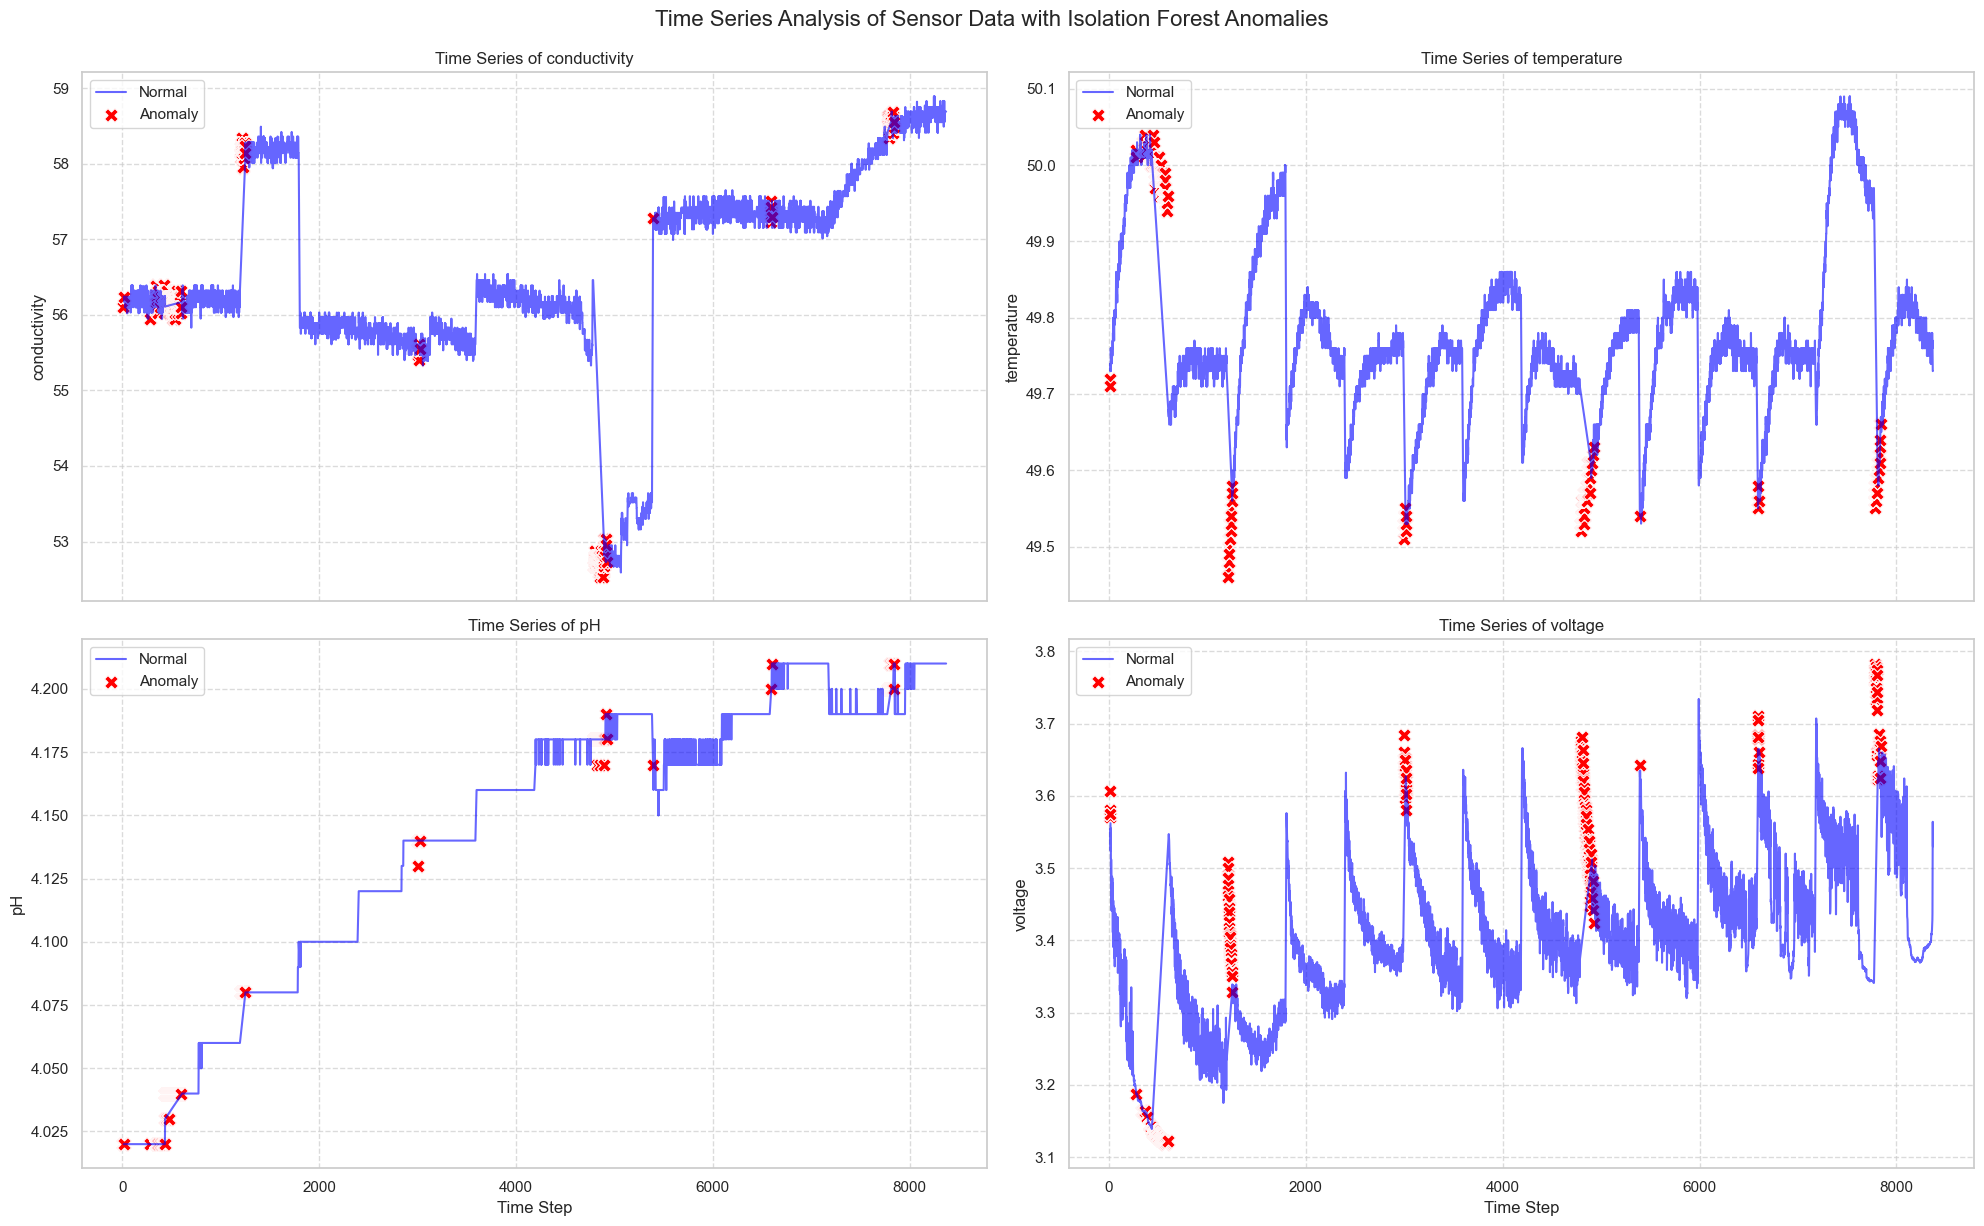

In [71]:
plot_anomaly_detection(X_score_train_df)

---

# Try test df

In [72]:
isolation_forest_pipeline = create_pipeline()
X_train_scaled = isolation_forest_pipeline.fit(filtered_test_df)

# The pipeline's predict method automatically calls transform on the preceding steps.
predictions = isolation_forest_pipeline.predict(filtered_test_df)

# --- Score Alignment (Mapping results back to original data is now the manual step) ---
# FIX: Access the retained index directly from the fitted transformer instance attribute.
retained_index = isolation_forest_pipeline.named_steps['feature_generator'].retained_index_

# Create a full results series initialized to 'Normal' (1)
results = pd.Series(1, index=filtered_test_df.index)

# Map the predictions back to the correct rows
results.loc[retained_index] = predictions

X_score_test_df = score_and_map_anomalies(isolation_forest_pipeline, filtered_test_df)
X_score_test_df

,run_id,conductivity,pH,temperature,voltage,index,timestamp,anomaly_score,is_anomaly
0,JUL_24_1,56.99,4.23,49.60,3.988,1,2025-07-24 09:26:30,NaN,NaN
1,JUL_24_1,56.85,4.23,49.61,3.868,2,2025-07-24 09:26:32,NaN,NaN
2,JUL_24_1,56.99,4.22,49.60,3.893,3,2025-07-24 09:26:34,NaN,NaN
3,JUL_24_1,56.99,4.22,49.61,3.833,4,2025-07-24 09:26:36,NaN,NaN
4,JUL_24_1,56.85,4.22,49.61,3.824,5,2025-07-24 09:26:38,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5965,JUL_24_10,56.58,4.27,49.98,3.928,594,2025-07-24 15:31:42,0.142912,1.0
5966,JUL_24_10,56.74,4.27,49.98,3.937,595,2025-07-24 15:31:44,0.146256,1.0
5967,JUL_24_10,56.74,4.27,49.97,3.901,596,2025-07-24 15:31:46,0.148029,1.0
5968,JUL_24_10,56.60,4.27,49.98,3.889,597,2025-07-24 15:31:48,0.149314,1.0


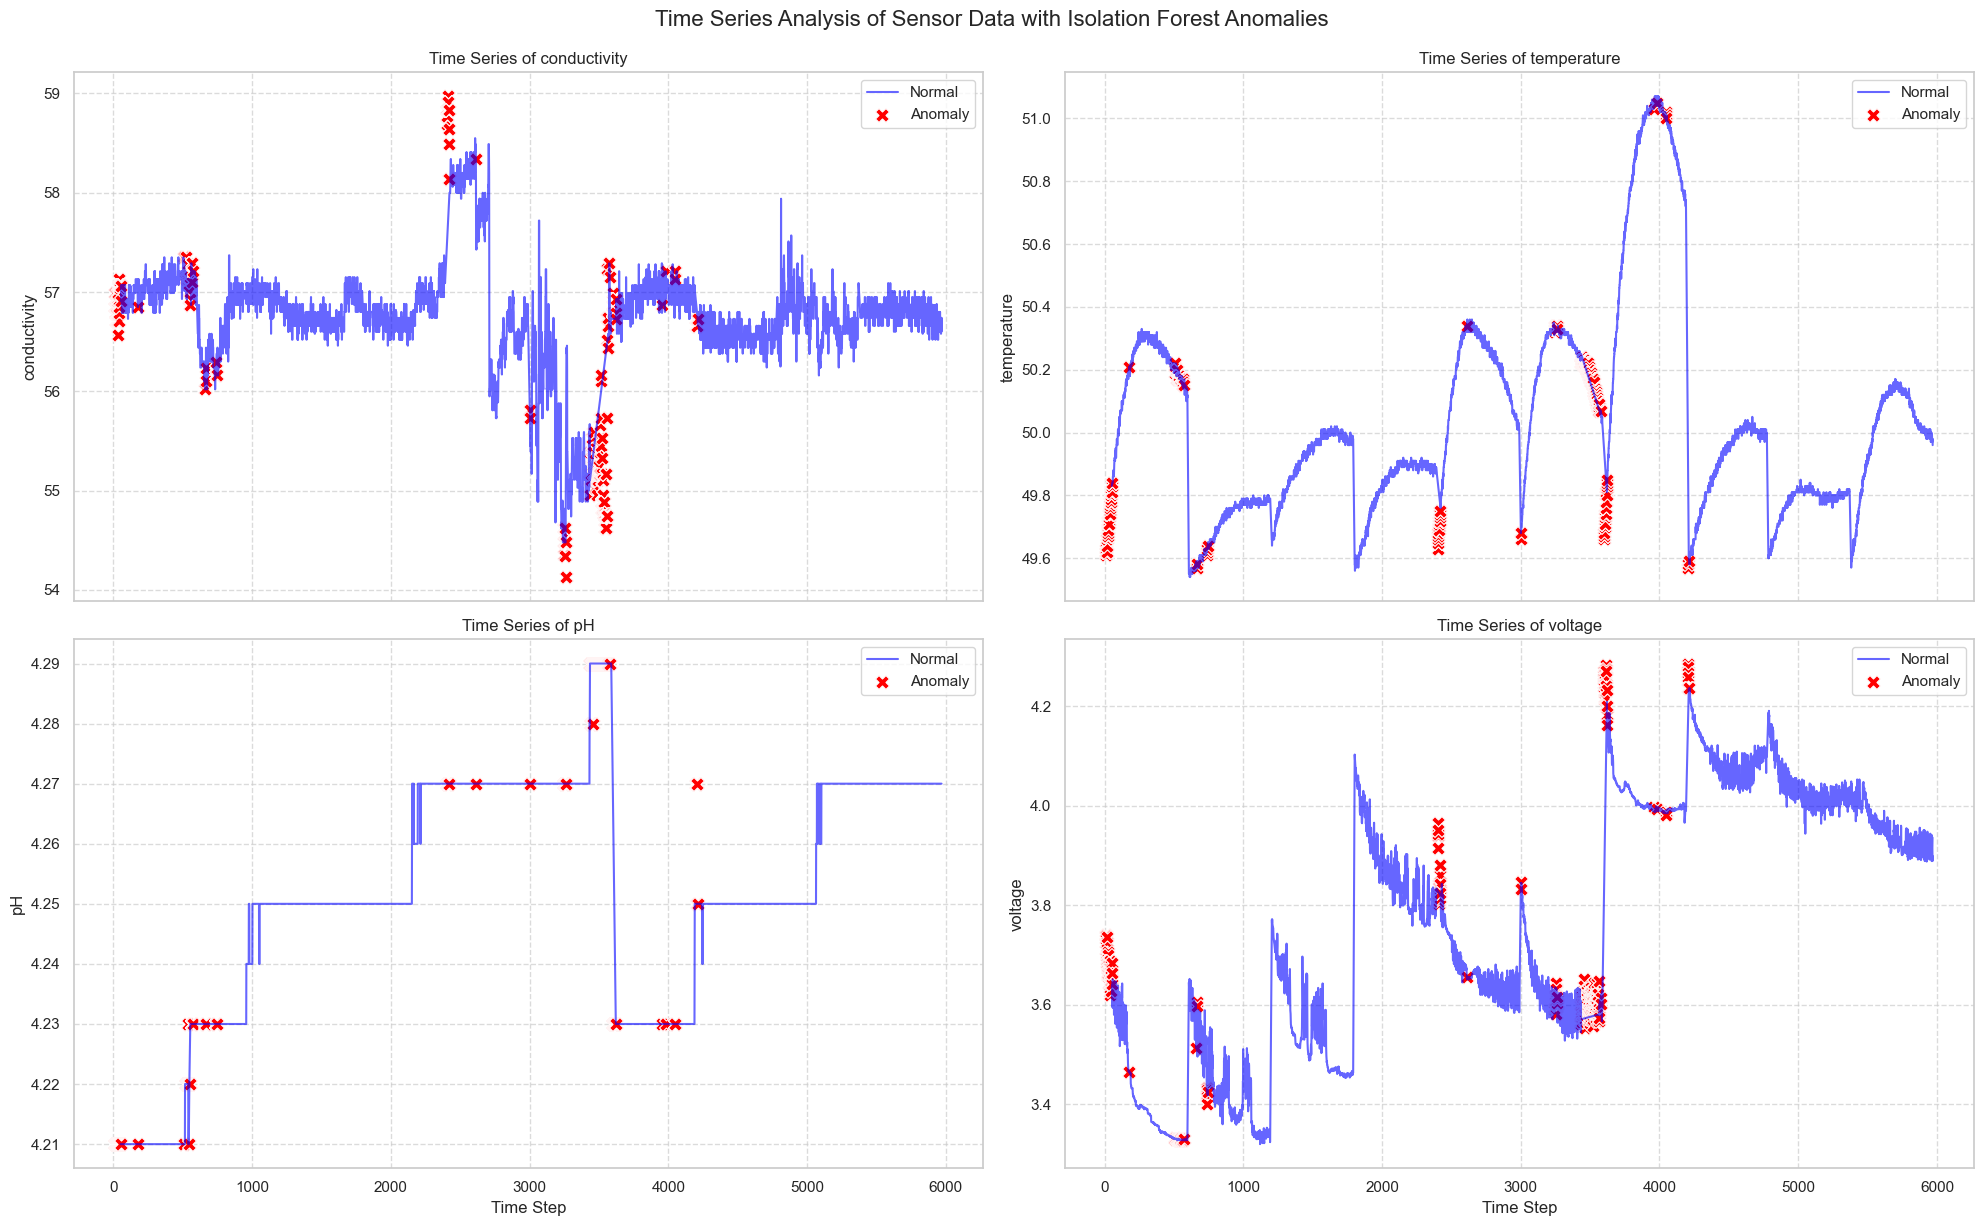

In [73]:
plot_anomaly_detection(X_score_test_df)

---

# Try Normal df

In [74]:
isolation_forest_pipeline = create_pipeline()
X_train_scaled = isolation_forest_pipeline.fit(filtered_normal_df)

# The pipeline's predict method automatically calls transform on the preceding steps.
predictions = isolation_forest_pipeline.predict(filtered_normal_df)

# --- Score Alignment (Mapping results back to original data is now the manual step) ---
# FIX: Access the retained index directly from the fitted transformer instance attribute.
retained_index = isolation_forest_pipeline.named_steps['feature_generator'].retained_index_

# Create a full results series initialized to 'Normal' (1)
results = pd.Series(1, index=filtered_normal_df.index)

# Map the predictions back to the correct rows
results.loc[retained_index] = predictions

X_score_normal_df = score_and_map_anomalies(isolation_forest_pipeline, filtered_normal_df)
X_score_normal_df

,run_id,conductivity,pH,temperature,voltage,index,timestamp,anomaly_score,is_anomaly
0,JUL_24_1,56.99,4.23,49.60,3.988,1,2025-07-24 09:26:30,NaN,NaN
1,JUL_24_1,56.85,4.23,49.61,3.868,2,2025-07-24 09:26:32,NaN,NaN
2,JUL_24_1,56.99,4.22,49.60,3.893,3,2025-07-24 09:26:34,NaN,NaN
3,JUL_24_1,56.99,4.22,49.61,3.833,4,2025-07-24 09:26:36,NaN,NaN
4,JUL_24_1,56.85,4.22,49.61,3.824,5,2025-07-24 09:26:38,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5965,JUL_24_10,56.58,4.27,49.98,3.928,594,2025-07-24 15:31:42,0.142912,1.0
5966,JUL_24_10,56.74,4.27,49.98,3.937,595,2025-07-24 15:31:44,0.146256,1.0
5967,JUL_24_10,56.74,4.27,49.97,3.901,596,2025-07-24 15:31:46,0.148029,1.0
5968,JUL_24_10,56.60,4.27,49.98,3.889,597,2025-07-24 15:31:48,0.149314,1.0


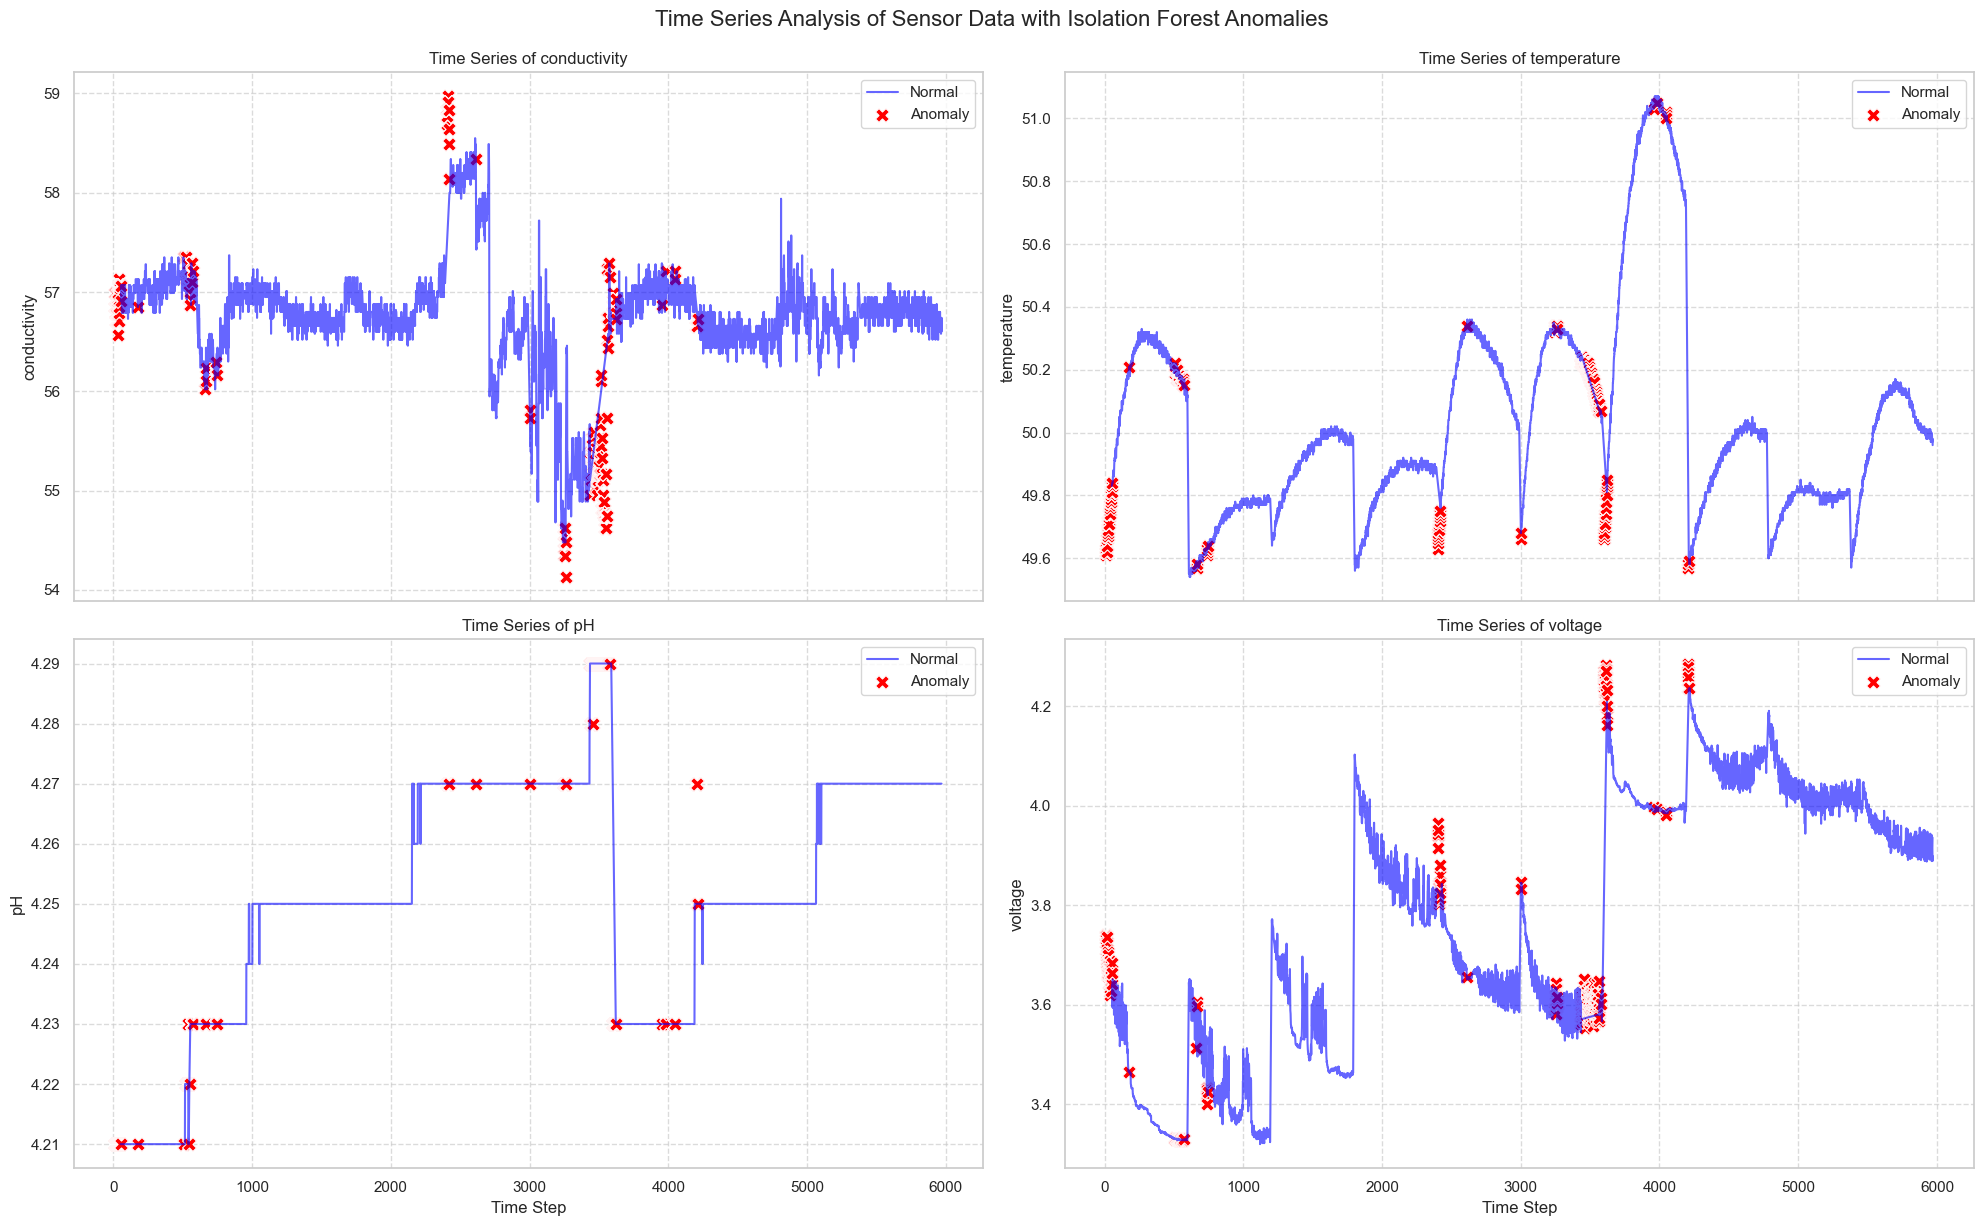

In [75]:
plot_anomaly_detection(X_score_normal_df)

---

# Try Normal Conductivity df

In [76]:
isolation_forest_pipeline = create_pipeline()
X_train_scaled = isolation_forest_pipeline.fit(filtered_normal_conductivity_df)

# The pipeline's predict method automatically calls transform on the preceding steps.
predictions = isolation_forest_pipeline.predict(filtered_normal_conductivity_df)

# --- Score Alignment (Mapping results back to original data is now the manual step) ---
# FIX: Access the retained index directly from the fitted transformer instance attribute.
retained_index = isolation_forest_pipeline.named_steps['feature_generator'].retained_index_

# Create a full results series initialized to 'Normal' (1)
results = pd.Series(1, index=filtered_normal_conductivity_df.index)

# Map the predictions back to the correct rows
results.loc[retained_index] = predictions

X_score_normal_conductivity_df = score_and_map_anomalies(isolation_forest_pipeline, filtered_normal_conductivity_df)
X_score_normal_conductivity_df

,run_id,conductivity,pH,temperature,voltage,index,timestamp,anomaly_score,is_anomaly
0,JUL_24_1,56.99,4.23,49.60,3.988,1,2025-07-24 09:26:30,NaN,NaN
1,JUL_24_1,56.85,4.23,49.61,3.868,2,2025-07-24 09:26:32,NaN,NaN
2,JUL_24_1,56.99,4.22,49.60,3.893,3,2025-07-24 09:26:34,NaN,NaN
3,JUL_24_1,56.99,4.22,49.61,3.833,4,2025-07-24 09:26:36,NaN,NaN
4,JUL_24_1,56.85,4.22,49.61,3.824,5,2025-07-24 09:26:38,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5965,JUL_24_10,56.58,4.27,49.98,3.928,594,2025-07-24 15:31:42,0.142912,1.0
5966,JUL_24_10,56.74,4.27,49.98,3.937,595,2025-07-24 15:31:44,0.146256,1.0
5967,JUL_24_10,56.74,4.27,49.97,3.901,596,2025-07-24 15:31:46,0.148029,1.0
5968,JUL_24_10,56.60,4.27,49.98,3.889,597,2025-07-24 15:31:48,0.149314,1.0


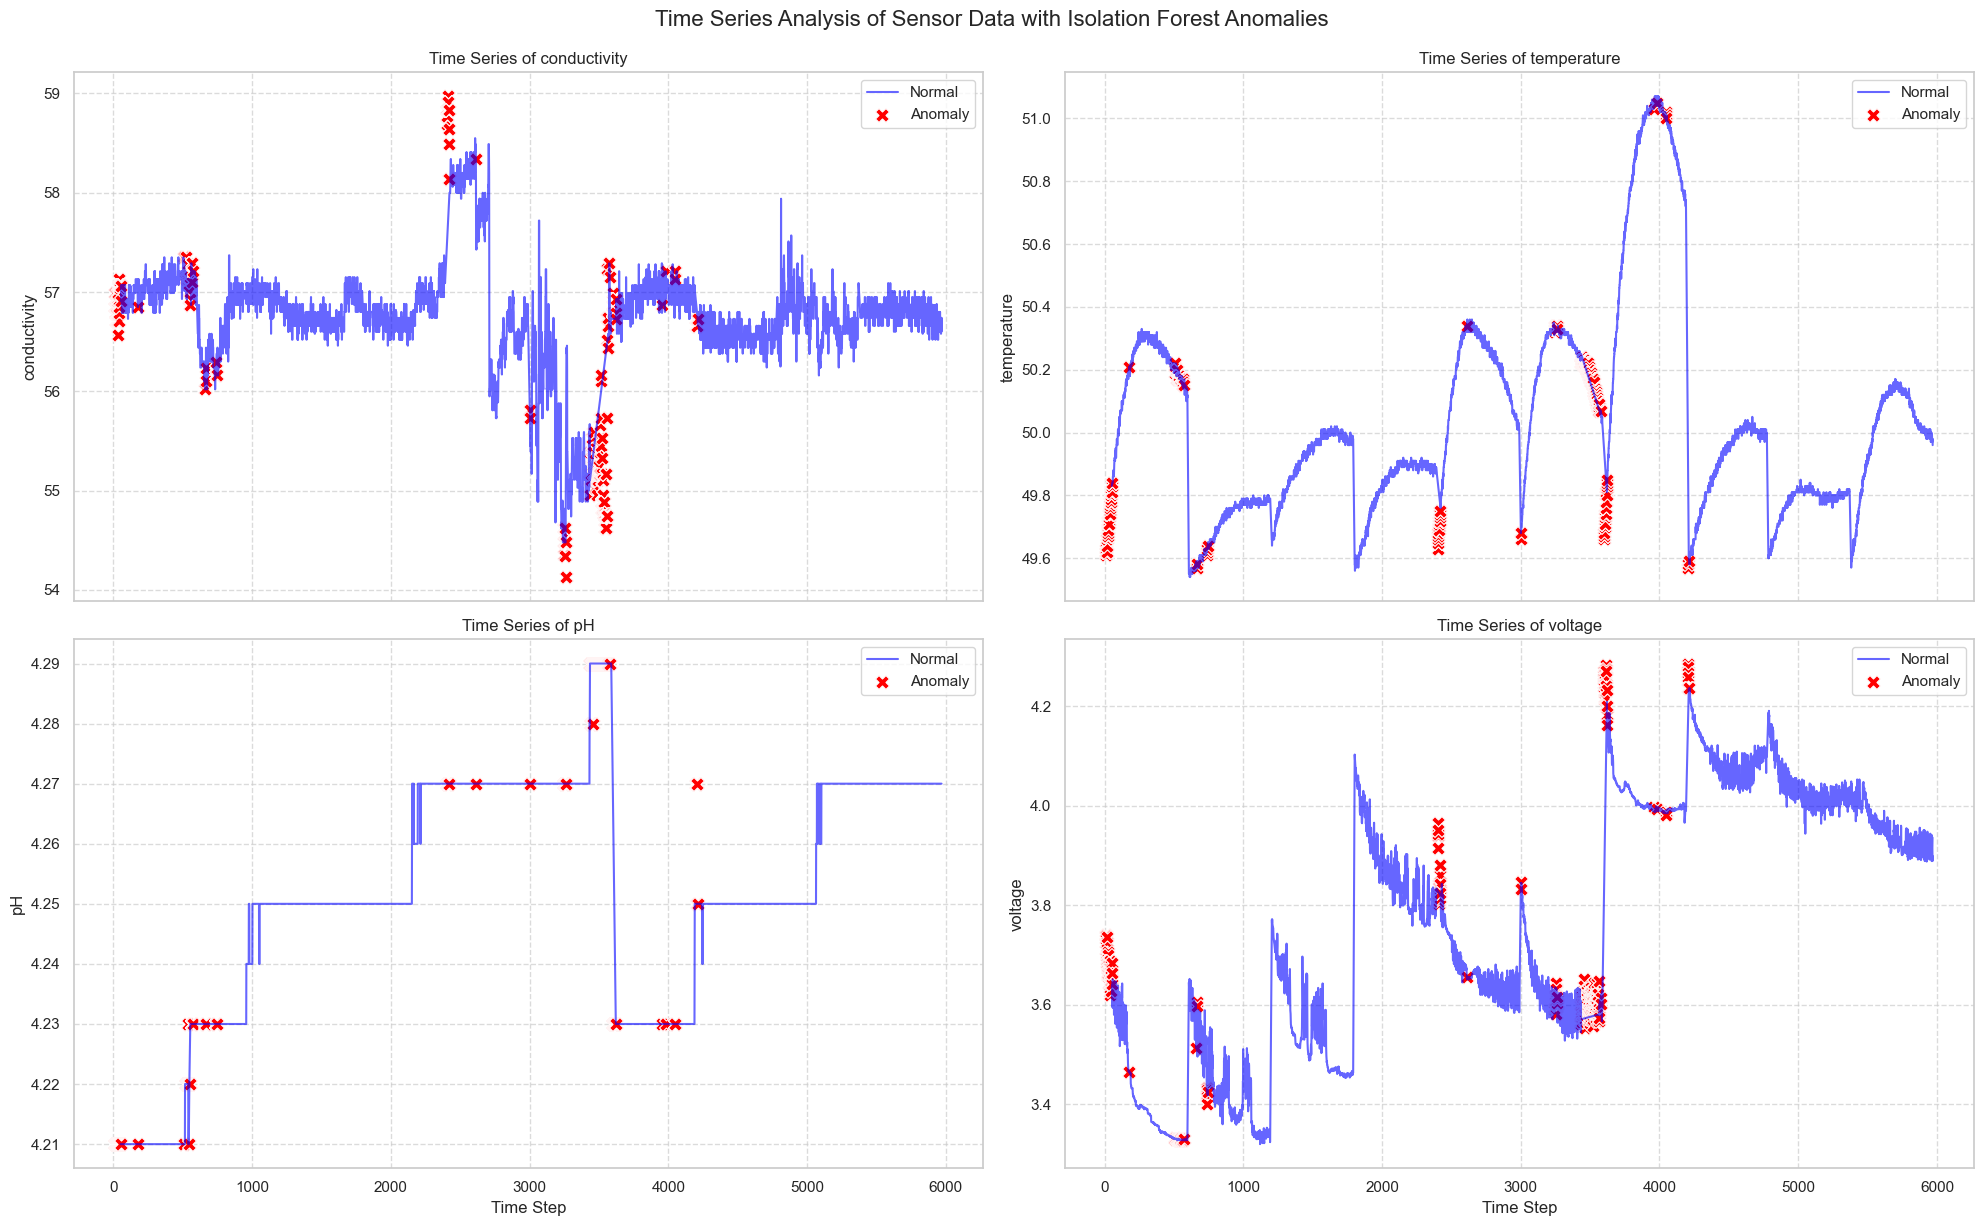

In [77]:
plot_anomaly_detection(X_score_normal_conductivity_df)

---

# Old one

In [78]:
BEST_CONTAMINATION_RATE = 0.03
print("--- Parameter Tuning: Contamination Rate ---")
# Candidates for the contamination rate (e.g., expecting 0.5% to 5% anomalies)
contamination_candidates = [0.005, 0.01, 0.02, 0.03, 0.05]
tuning_results = {}

# Iterate over candidates and report
for rate in contamination_candidates:
    count, _ = tuning_contamination_rate(isolation_forest_pipeline, rate, filtered_normal_conductivity_df)
    tuning_results[rate] = count
    print(f"Contamination Rate: {rate*100:.1f}% | Detected Anomalies: {count}")

print("\nBased on these results, you would typically select a rate that detects a reasonable number of anomalies and captures known anomalies (like the spike at index 35).")
print(f"Selecting {BEST_CONTAMINATION_RATE*100:.1f}% for final run and visualization.")

--- Parameter Tuning: Contamination Rate ---
Contamination Rate: 0.5% | Detected Anomalies: 30
Contamination Rate: 1.0% | Detected Anomalies: 59
Contamination Rate: 2.0% | Detected Anomalies: 118
Contamination Rate: 3.0% | Detected Anomalies: 177
Contamination Rate: 5.0% | Detected Anomalies: 294

Based on these results, you would typically select a rate that detects a reasonable number of anomalies and captures known anomalies (like the spike at index 35).
Selecting 3.0% for final run and visualization.


In [79]:
# ----------------------------------------------------------------------
# --- 4. Output and Analysis
# ----------------------------------------------------------------------
anomaly_counts = results.value_counts().rename({1: 'Normal', -1: 'Anomaly'})
print("--- Full Anomaly Pipeline Training and Prediction Complete ---")
print(f"Total Rows Analyzed: {filtered_normal_conductivity_df.shape[0]}")
print(f"Predictions (1: Normal, -1: Anomaly):\n{anomaly_counts}")

print("\n--- Anomaly Index Check ---")
# Find the indices of the detected anomalies
anomaly_indices = results[results == -1].index.tolist()
print(f"Anomaly indices detected in the original DataFrame: {anomaly_indices}")

# Example of final data output with anomaly label appended (for visualization)
filtered_normal_conductivity_df['Anomaly_Label'] = results
print("\n--- Data Sample with Anomaly Label (Anomalies Only) ---")
print(filtered_normal_conductivity_df[filtered_normal_conductivity_df['Anomaly_Label'] == -1])

--- Full Anomaly Pipeline Training and Prediction Complete ---
Total Rows Analyzed: 5970
Predictions (1: Normal, -1: Anomaly):
Normal     5676
Anomaly     294
Name: count, dtype: int64

--- Anomaly Index Check ---
Anomaly indices detected in the original DataFrame: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 178, 505, 506, 507, 520, 521, 522, 532, 533, 534, 535, 536, 537, 541, 544, 545, 546, 548, 549, 550, 551, 552, 553, 563, 564, 565, 566, 575, 661, 664, 665, 738, 739, 740, 741, 742, 743, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2612, 3000, 3002, 3245, 3247, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3260, 3261, 3262, 3263, 3264, 3434, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 34

/var/folders/fd/5wd3mqp94mz3pq009lxrc6yw0000gn/T/ipykernel_38519/943798745.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_normal_conductivity_df['Anomaly_Label'] = results


/var/folders/fd/5wd3mqp94mz3pq009lxrc6yw0000gn/T/ipykernel_38519/2339589865.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_normal_conductivity_df['Anomaly_Label_Str'] = filtered_normal_conductivity_df['Anomaly_Label'].astype(str)


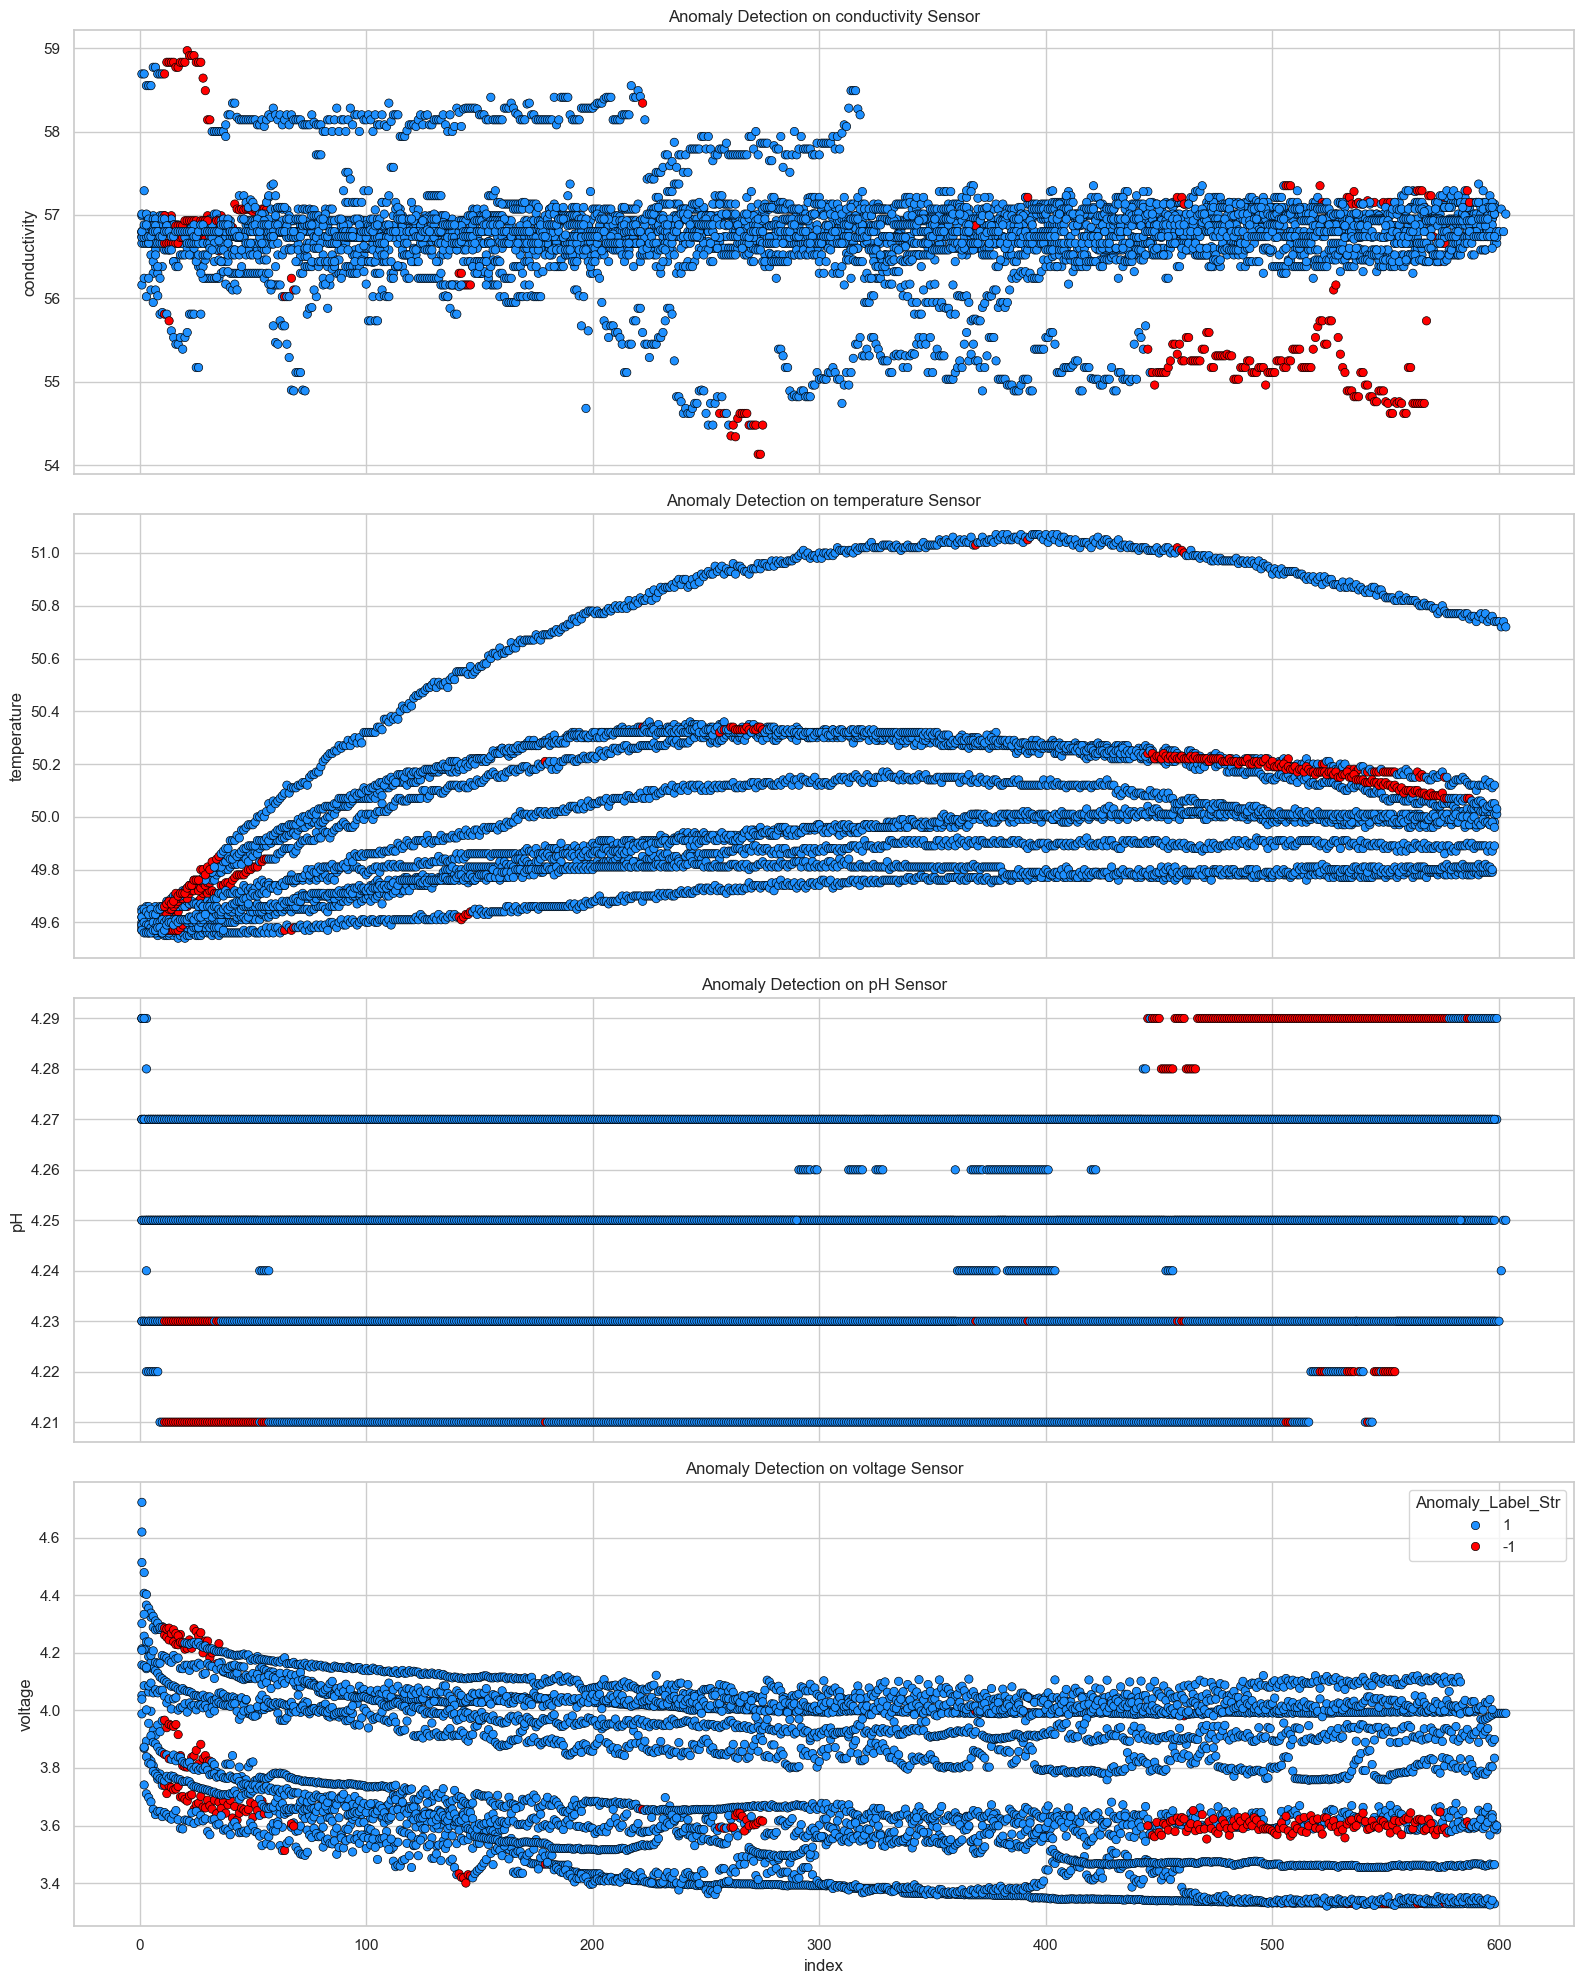

In [80]:
# Create a figure with subplots (optional, but cleaner)
fig, axes = plt.subplots(4, 1, figsize=(16, 20), sharex=True) 
SENSOR_FEATURES = ["conductivity", "temperature", "pH",	"voltage"]
filtered_normal_conductivity_df['Anomaly_Label_Str'] = filtered_normal_conductivity_df['Anomaly_Label'].astype(str)

for i, sensor in enumerate(SENSOR_FEATURES):
	# Plotting each sensor against the timestamp
	sns.scatterplot(
		data=filtered_normal_conductivity_df,
		x='index',
		y=sensor, # Iterating over the sensor column
		hue='Anomaly_Label_Str', 
		palette={'1': 'dodgerblue', '-1': 'red'}, 
		sizes={'1': 50, '-1': 200}, 
		ax=axes[i], # Assigning plot to the correct subplot
		edgecolor='black',
		legend=False if i < len(SENSOR_FEATURES) - 1 else 'full' # Only show legend on the last plot
	)
	axes[i].set_title(f'Anomaly Detection on {sensor} Sensor')
	# axes[i].set_xlabel('Timestamp', fontsize=12)

plt.tight_layout()
plt.show()